In [ ]:
# Bootstrap if in colab etc
!git clone https://github.com/JWSTMassiveGalaxies/outthere-example-notebooks.git data

In [ ]:
cd data

In [ ]:
!pip install -r requirements.txt

In [2]:
#import time
import astropy.wcs as pywcs
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
myfontsize=22
plt.rcParams.update({'font.size': myfontsize})
plt.rcParams["text.usetex"] = False
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter, NullFormatter,MaxNLocator, NullLocator,LogLocator
from grizli.utils import get_line_wavelengths 
from grizli import utils
%matplotlib inline

#import some useful functions
from outthere_notebook_utils import get_cmap, get_lines,get_2dspectra,show_drizzled_lines,scale_bar
#Taking color scheme from Grizli
grism_colors={'F115W': (0.0, 0.6196078431372549, 0.45098039215686275),
              'F150W': (0.8352941176470589, 0.3686274509803922, 0.0),
              'F200W': (0.8, 0.4745098039215686, 0.6549019607843137)}



root='outthere-hudfn'
object_id = 4375
catalog_ver='v0.1'


In [ ]:
# Get catalog data if needed
url = "https://data.outthere-survey.org/0.1/Catalogs"
user = "" # <username>
password = "" # <password>
!wget --user="{user}" --password="{password}" {url}/outthere-hudfn_redshift_v0.1.fits
!wget --user="{user}" --password="{password}" {url}/outthere-hudfn_lines_v0.1.fits
!wget --user="{user}" --password="{password}" {url}/outthere-hudfn_CANDELS_crossmatched_v0.1.fits

# Read Grizli's Outputs

The data products listed below are provided for each source in OutThere/HUDFN Grism redshift catalog with  F200W < 26.5 AB mag. 

A. outthere-hudfn_04375.1D.fits: A multi-extension FITS file of 1D spectra of each bandpass with the extension name corresponds to grism filter (when available).

B. outthere-hudfn_04375.beams.fits: A multi-extension FITS file contains 2D image cutout of reference image, segmentation map, and
extracted 2D spectra (science image, error image, DQ, modeled contamination), and trace for individual grism exposures and bandpasses. 

C. outthere-hudfn_04375.full.fits: A multi-extension contains the result from Grizli redshift fitting. 

D. outthere-hudfn_04375.stack.fits: A multi-extension FITS file of 2D spectra of each bandpass. The description of each extension is explained below. We refer the user to our example IPython Notebook for reading and plotting 2D spectra. 

A summary PDF file ("biopage") for each object, containing cutout images, 2D, 1D spectra, and p(z) is available for each source in the catalog.

In [3]:
#read 1D spectra 
spec1d_hdul = fits.open('%s_%s.1D.fits' % (root,str(object_id).zfill(5)))
#spec1d_hdul.info()
filters = [spec1d_hdul[0].header['GR*'][i] for i in range(len(spec1d_hdul[0].header['GR*']))]
print('Observed filters:', filters)

# read grizli's spectral fitting output
full_hdul = fits.open('%s_%s.full.fits' % (root,str(object_id).zfill(5)))


# read stacked 2D spectra
spec2d_hdul = fits.open('%s_%s.stack.fits' % (root,str(object_id).zfill(5)))

# read cutout image, segmentation map, and individual beams
beam_hdul = fits.open('%s_%s.beams.fits' % (root,str(object_id).zfill(5)))


Observed filters: ['F150W', 'F200W']


In [4]:
# view basic information
full_hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                 4375 / Object ID                                      
RA      =   189.27958644264336 / Central R.A.                                   
DEC     =   62.197933236480495 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                   14 / Number of drizzled beams                       
FILE0001= 'jw03383090001_04201_00003_nis_rate.fits' / Parent filename           
GRIS0001= 'GR150C  '           / Beam grism element                             
PA0001  =                318

## Extracting emission line properties

We also provide a function for reading and extracting the line flux, line flux error, and the rest-frame equivalent width (median, 16th percentile, and 84th percentile) for each emisision lines, given the minimum threshold in the signal-to-noise raio.


In [5]:

# extracting properties of emission lines with snr>5
lines_prop_dict = get_lines(full=full_hdul,min_snr=5)
lines_prop_dict

{'name': ['Ha', 'OIII', 'Hb'],
 'wavelength_obs': {'Ha': 21500.301950065626,
  'OIII': 16402.68731952087,
  'Hb': 15926.147894420448},
 'flux': {'Ha': 1.90487098197382e-17,
  'OIII': 5.98897860084764e-17,
  'Hb': 1.11021740568803e-17},
 'flux_err': {'Ha': 1.09413065929338e-18,
  'OIII': 1.28720759986696e-18,
  'Hb': 8.67103753270031e-19},
 'snr_line': {'Ha': 17.409904071274617,
  'OIII': 46.526905228547704,
  'Hb': 12.803743513981646},
 'snr_ew': {'Ha': 10.133299252505001,
  'OIII': 21.63382274337305,
  'Hb': 12.025073955866292},
 'ew_16': {'Ha': 377.3582218593502,
  'OIII': 583.425086885794,
  'Hb': 122.70299041091532},
 'ew_50': {'Ha': 417.222537329779,
  'OIII': 612.787733207716,
  'Hb': 133.73481650800133},
 'ew_84': {'Ha': 459.7050522318253,
  'OIII': 640.0759839997058,
  'Hb': 144.94565053904873}}

# Display image cutout and segmentation map

reference bands: ['F150W' 'F200W']


(-0.5, 95.5, -0.5, 95.5)

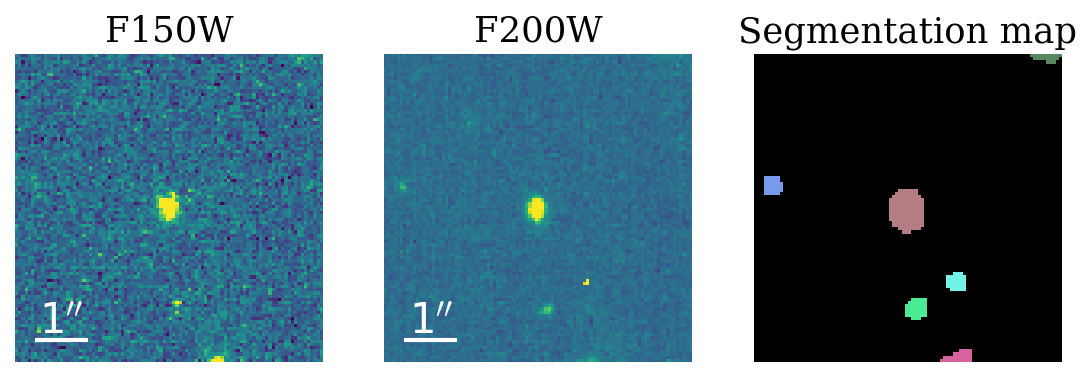

In [6]:
# Get indices of FITS hdu which are references images        
plt.rcParams["text.usetex"] = False
ref_indices =[]
ref_filters =[]
for i in range(len(beam_hdul)):
    try:
        if beam_hdul[i].header['EXTNAME']=='REF':
            #print(beam_hdul[i].header['PUPIL'])
            ref_indices.append(i)
            ref_filters.append(beam_hdul[i].header['PUPIL'])
    except:
        pass
ref_indices= np.array(ref_indices)
ref_filters = np.array(ref_filters)
ref_filters_list = np.unique(ref_filters)
print('reference bands:',ref_filters_list)

fig,axs= plt.subplots(1,len(ref_filters_list)+1,figsize=(4*len(ref_filters_list)+1,4),dpi=150)
axs=axs.ravel()
for i in range(len(ref_filters_list)):
    sel = (np.where(ref_filters==ref_filters_list[i]))[0]
    hdul_ind= ref_indices[sel[0]]
    deltaPix= beam_hdul[hdul_ind].header['PIXSCALE'] # pixel scale
    ref_im=  beam_hdul[hdul_ind].data
    
    if i==0:
        z = ZScaleInterval()
        zmin,zmax = z.get_limits(ref_im)
    axs[i].imshow(ref_im,origin='lower',vmin=zmin,vmax=zmax)
    if ref_filters_list[i]=='F200W': # show segmentation map for F200W band 
        seg_im=  beam_hdul[hdul_ind+1].data
        segmap_cmap=get_cmap(seg_im)
        axs[i+1].imshow(seg_im,origin='lower',cmap=segmap_cmap)

    axs[i].axis('off')
    axs[i].set_title('%s' % ref_filters_list[i] ,fontsize=myfontsize-5)
    scale_bar(axs[i], np.shape(ref_im)[0], dist=1/deltaPix, text=r'$1^{\prime \prime}$',
              fontsize=myfontsize-2,color='w')
axs[-1].set_title('Segmentation map',fontsize=myfontsize-5) 
axs[-1].axis('off')  

# Plot 1D spectra

For each filter, we will read the 1D spectra, the corresponding error, modeled continuum, and modeled contamination. In this example, the 1D spectra (its error) for each band are plotted for simplicity. Then the emission lines with SNR greater than a given threshold are indicated in the plot. 

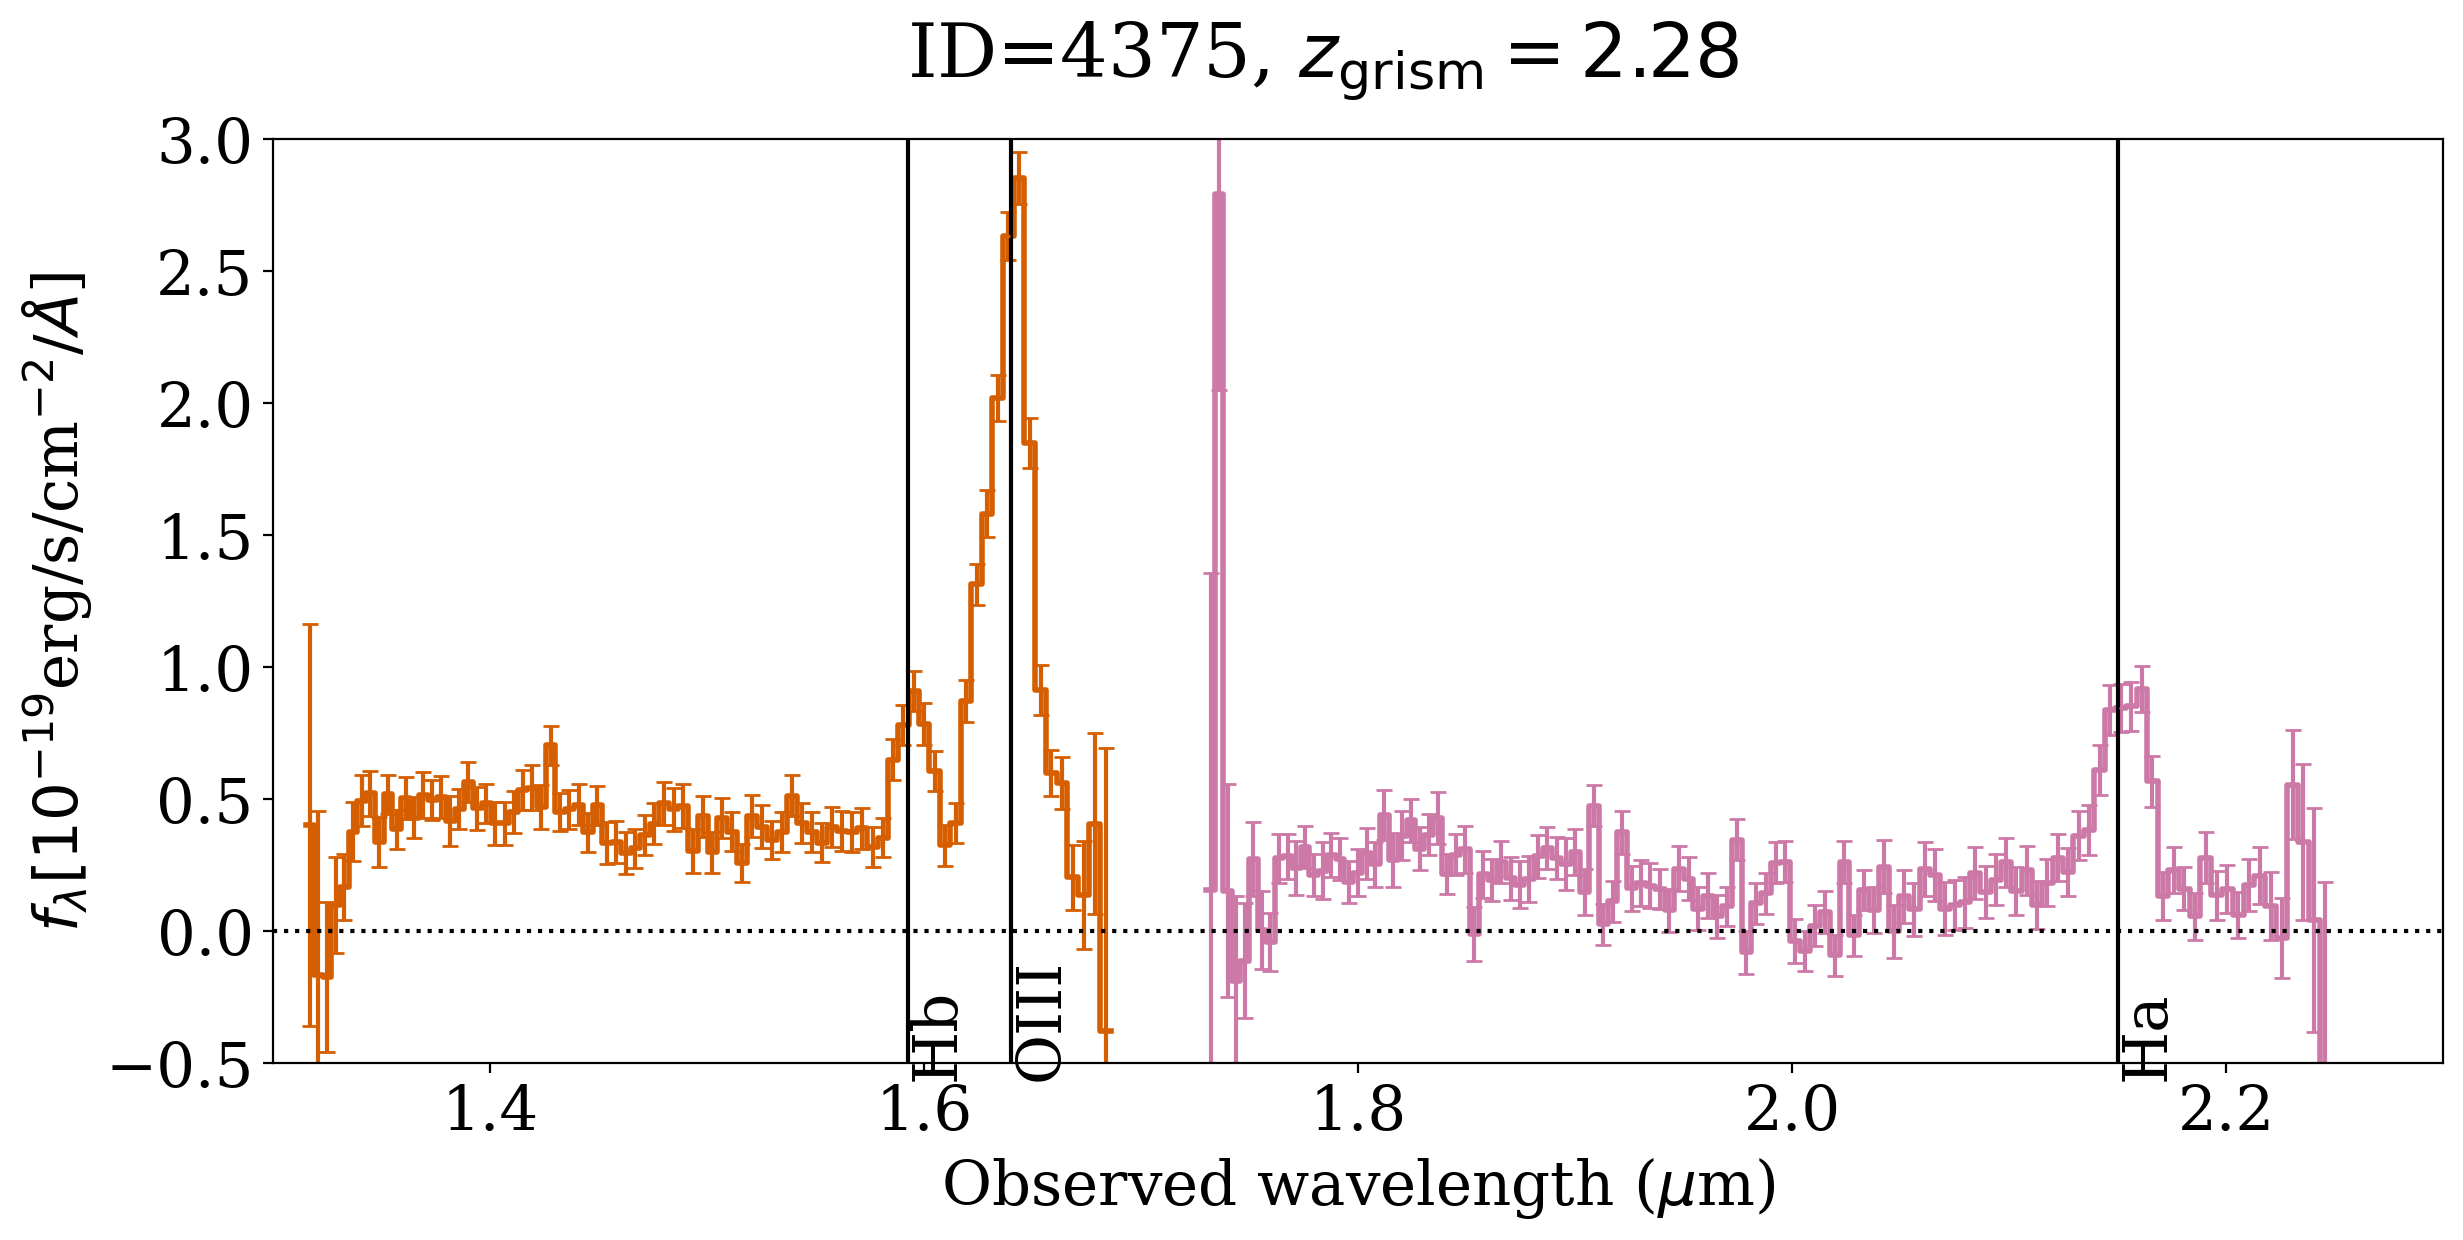

In [7]:
label_each_lines=True # add label to each emission line?
fig,ax= plt.subplots(figsize=(14,6),dpi=200)

for i in range(len(filters)):
    spec1d = Table(spec1d_hdul[filters[i]].data)
    flux =(spec1d['flux']/spec1d['flat'])/(1.e-19 ) # 1D spectra
    err = (spec1d['err']/spec1d['flat'])/(1.e-19 ) 
    cont=(spec1d['cont']/spec1d['flat'])/(1.e-19 ) # continuum model
    contam= (spec1d['contam']/spec1d['flat'])/(1.e-19 ) # contamination model 
                       
    ax.step(spec1d['wave']/(1e+4),flux,
    color=grism_colors[filters[i]],where='mid',linestyle='-',label='lines',lw=2)
    ax.errorbar(spec1d['wave']/(1e+4),flux,yerr=err,
                ecolor=grism_colors[filters[i]],marker='o',mfc=grism_colors[filters[i]],
                mec=grism_colors[filters[i]],color='none',ms=0.5,capsize=3)

ax.set_xlim(1.3,2.3)
ax.set_ylim(-0.5,3)
ax.axhline(y=0,color='k',ls=':')
ax.set_xlabel(r'Observed wavelength ($\mu$m)')
ax.set_ylabel(r'$f_{\lambda}[10^{-19}$erg/s/cm$^{-2}/\AA$]')
ymin,ymax=ax.get_ylim()
fig.suptitle(r'ID=%d, $z_{\mathrm{grism}}=%.2f$' % (full_hdul[0].header['ID'],
                                                    full_hdul[0].header['REDSHIFT']),fontsize=myfontsize+5)
if (label_each_lines==True) & (len(lines_prop_dict['name'])>0):
 
    for i in range(len(lines_prop_dict['name'])):
        linename= lines_prop_dict['name'][i]
        ax.axvline(x=lines_prop_dict['wavelength_obs'][linename]/10000.0,color='k' )
        ax.text(lines_prop_dict['wavelength_obs'][linename]/10000.0,ymin-0.005*ymax,
                '%s'  % lines_prop_dict['name'][i],fontsize=myfontsize,
                       rotation=90)

# Plot Emission Line Maps

full_line_list ['Ha', 'OIII', 'Hb']


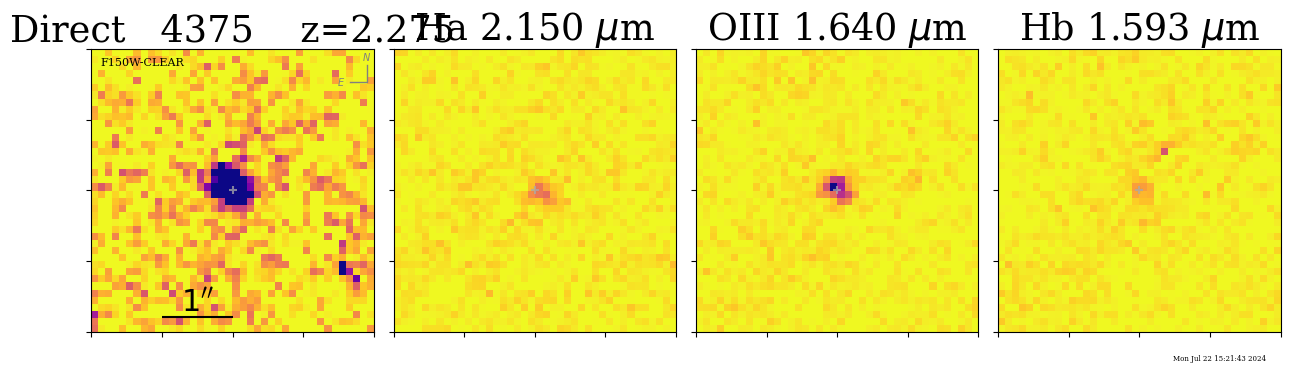

In [8]:
# Plot emission line maps for lines with SNR>5
line_size=1.6
dscale=1./4
scale_linemap=1 
#full_line_list=['OII', 'Hb', 'OIII', 'Ha+NII', 'Ha', 'SII', 'SIII']

fig = show_drizzled_lines(full_hdul, full_line_list=lines_prop_dict['name']) 
        


# Plot 2D spectra

The user can find the 2D array of science grism image (EXT='SCI'), weight map (EXT='WHT'), and the model continuum (EXT='MODEL') for BAND ='F200W', combining all grism orientations (PA), by specifying the extension name with the format of ['EXT', 'BAND']. 

To read the science grism images, weight map, modeled continuum (EXT='MODEL'), and modeled contamination (EXT='CONT') for individual grism orientation, the user can specify the fits extension name with the format of ['EXT','BAND,PA']. We note that the modeled contamination image is not available for the combined PAs -- it will only available for each grism PA. For example, the extension name of ['CONTAM, 'F200W'] does not exist.

In [9]:
#To see which PA(s) are available for each filter, the user can print 
spec2d_hdul[0].header['F150W0*'] 

F150W01 =                318.0 / PA                                             
F150W02 =                319.0 / PA                                             

In [10]:
spec2d_hdul[0].header['F200W0*'] 

F200W01 =                319.0 / PA                                             

In [11]:
spec2d_sci_combinedPA = spec2d_hdul['SCI','F200W'].data # sci grism image
spec2d_wht_combinedPA = spec2d_hdul['WHT','F200W'].data # weight map
spec2d_model_combinedPA = spec2d_hdul['MODEL','F200W'].data # modeled continuum image
#the spec2d_hdul['CONTAM','F200W'].data is not available


# for PA=318.0
spec2d_sci = spec2d_hdul['SCI','F150W,318.0'].data
spec2d_wht =  spec2d_hdul['WHT','F150W,318.0'].data
spec2d_model =  spec2d_hdul['MODEL','F150W,318.0'].data
spec2d_contam = spec2d_hdul['CONTAM','F150W,318.0'].data


 We will use a python function "get_2dspectra" to read all extensions of the 2D grism spectra file ("outthere-hudfn_04375.beams.fits") and plot them.

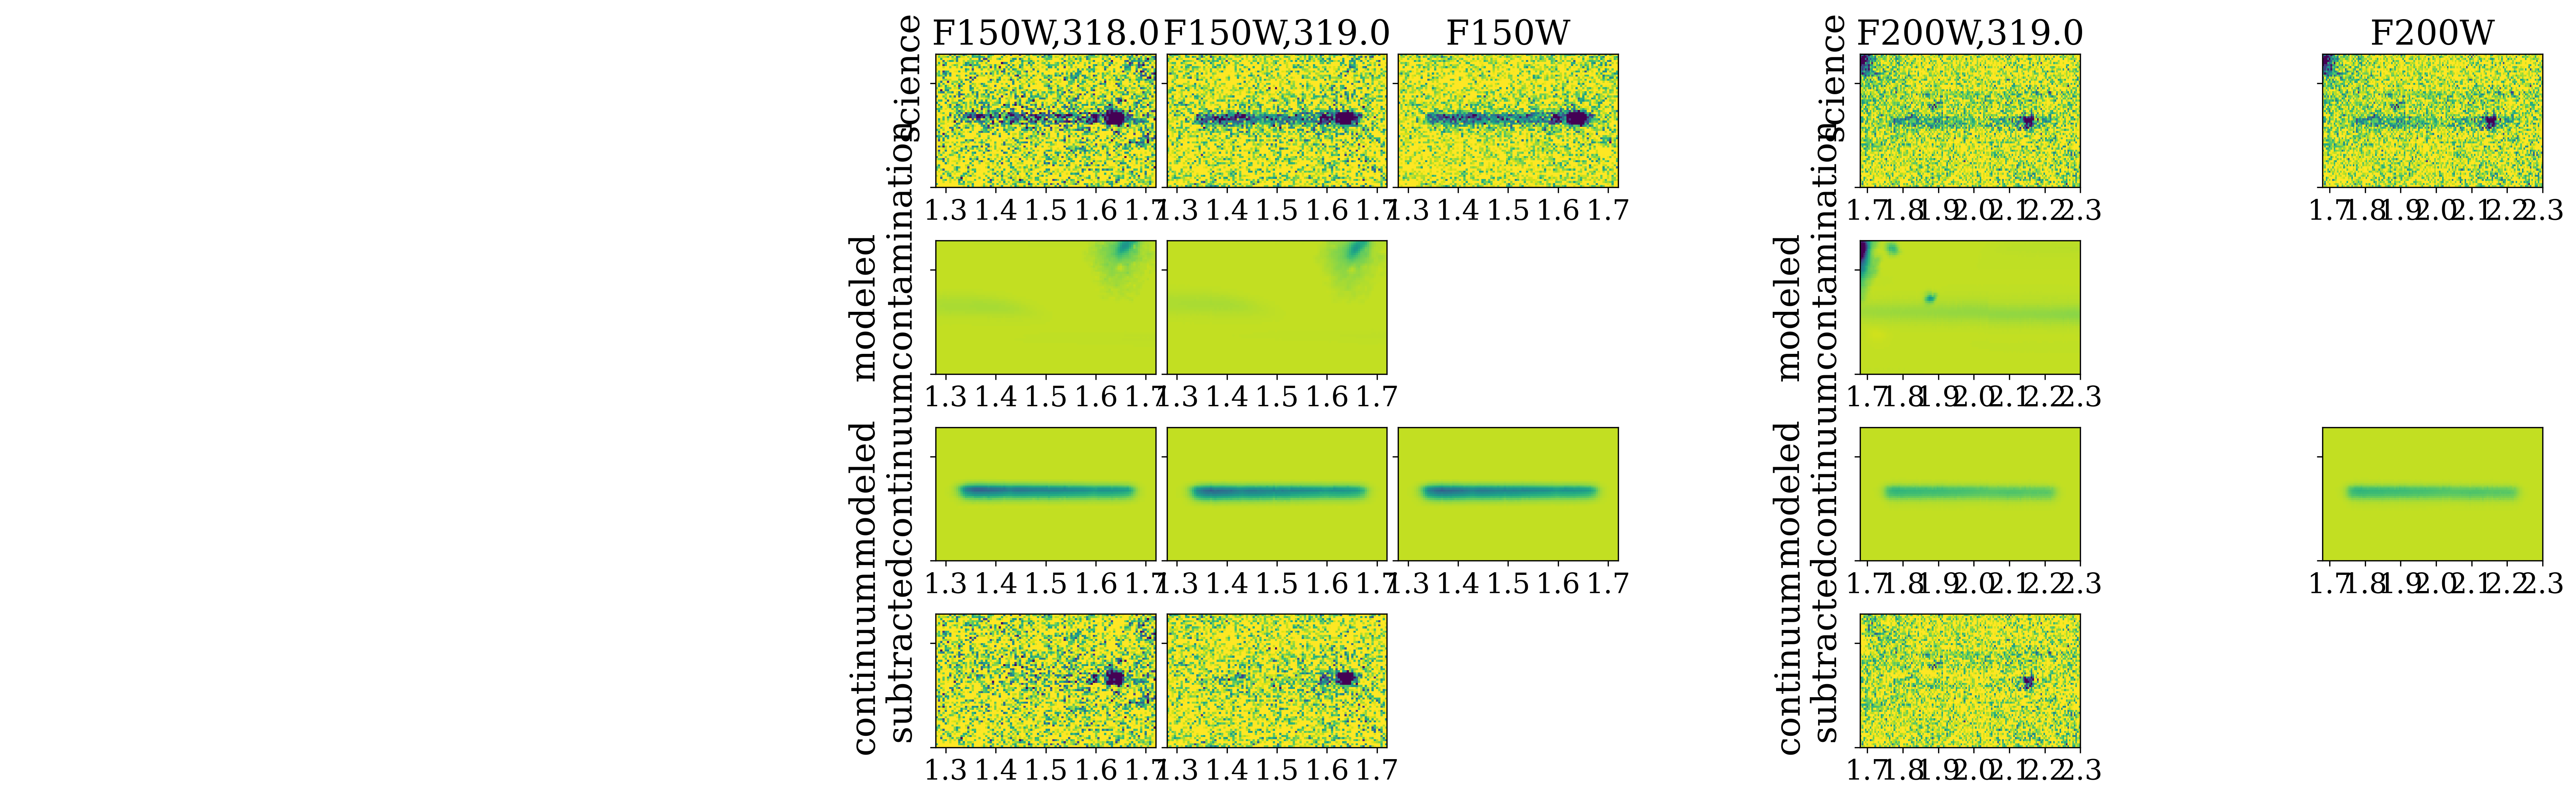

In [12]:

# Set up a plot 
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(25,8))
gs1 = fig.add_gridspec(nrows=4, ncols=11, left=0.05, right=0.95,
                        wspace=0.05,hspace=0.4)

row=-1
axs_sci_f115w= [fig.add_subplot(gs1[row+1, 0]),fig.add_subplot(gs1[row+1, 1]),fig.add_subplot(gs1[row+1, 2])]
axs_sci_f150w= [fig.add_subplot(gs1[row+1,4]),fig.add_subplot(gs1[row+1, 5]),fig.add_subplot(gs1[row+1, 6])]
axs_sci_f200w= [fig.add_subplot(gs1[row+1,8]),fig.add_subplot(gs1[row+1, 9]),fig.add_subplot(gs1[row+1, -1])]

axs_cont_f115w= [fig.add_subplot(gs1[row+2, 0]),fig.add_subplot(gs1[row+2, 1]),fig.add_subplot(gs1[row+2, 2])]
axs_cont_f150w= [fig.add_subplot(gs1[row+2,4]),fig.add_subplot(gs1[row+2, 5]),fig.add_subplot(gs1[row+2, 6])]
axs_cont_f200w= [fig.add_subplot(gs1[row+2,8]),fig.add_subplot(gs1[row+2, 9]),fig.add_subplot(gs1[row+2, -1])]

axs_model_f115w= [fig.add_subplot(gs1[row+3, 0]),fig.add_subplot(gs1[row+3, 1]),fig.add_subplot(gs1[row+3, 2])]
axs_model_f150w= [fig.add_subplot(gs1[row+3,4]),fig.add_subplot(gs1[row+3, 5]),fig.add_subplot(gs1[row+3, 6])]
axs_model_f200w= [fig.add_subplot(gs1[row+3,8]),fig.add_subplot(gs1[row+3, 9]),fig.add_subplot(gs1[row+3, -1])]
# # Sci image - continuum
axs_conti_subtracted_f115w= [fig.add_subplot(gs1[row+4, 0]),fig.add_subplot(gs1[row+4, 1]),fig.add_subplot(gs1[row+4, 2])]
axs_conti_subtracted_f150w= [fig.add_subplot(gs1[row+4,4]),fig.add_subplot(gs1[row+4, 5]),fig.add_subplot(gs1[row+4, 6])]
axs_conti_subtracted_f200w= [fig.add_subplot(gs1[row+4,8]),fig.add_subplot(gs1[row+4, 9]),fig.add_subplot(gs1[row+4, -1])]

# show 2D spectra (science), modeled contamination, and modeled continuum
axs_f115w_spec2d= np.array([axs_sci_f115w,axs_cont_f115w,axs_model_f115w,axs_conti_subtracted_f115w])
axs_f150w_spec2d= np.array([axs_sci_f150w,axs_cont_f150w,axs_model_f150w,axs_conti_subtracted_f150w])
axs_f200w_spec2d= np.array([axs_sci_f200w,axs_cont_f200w,axs_model_f200w,axs_conti_subtracted_f200w])

          

get_2dspectra(hdu=spec2d_hdul,axs_f115w=axs_f115w_spec2d,
              axs_f150w=axs_f150w_spec2d,axs_f200w=axs_f200w_spec2d)
if 'F115W' not in  filters:
    axs=axs_f115w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
if 'F150W' not in filters:
    axs=axs_f150w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
if 'F200W' not in filters:
    axs=axs_f200w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
for axs in [axs_f115w_spec2d,axs_f150w_spec2d,axs_f200w_spec2d]:
    axs=axs.ravel()
    for ax in axs:
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize=myfontsize-4)

# Plot P(z)

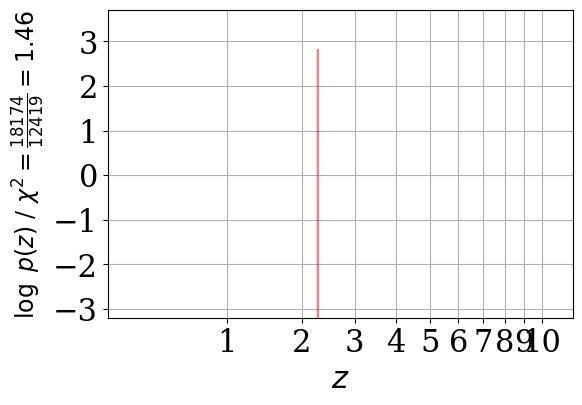

In [13]:
fig,axz= plt.subplots(figsize=(6,4),dpi=100)

zfit_stack=full_hdul['ZFIT_STACK'].data
zgrid = zfit_stack['zgrid']
pdf =zfit_stack['pdf']
zmi, zma = zgrid.min(), zgrid.max()
if (zma-zmi) > 5:
    ticks = np.arange(np.ceil(zmi), np.floor(zma), 1)
    lz = np.log(1+zgrid)
    axz.plot(lz, np.log10(pdf), color='red', alpha=0.5)
    axz.set_xticks(np.log(1+ticks))
    axz.set_xticklabels(np.cast[int](ticks))
    axz.set_xlim(lz.min(), lz.max())
else:
    axz.plot(zgrid, np.log10(pdf), color='red', alpha=0.5)
    axz.set_xlim(zmi, zma)
axz.set_xlabel(r'$z$')
axz.set_ylabel(r'$\log\ p(z)$'+' / ' + r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(full_hdul['ZFIT_STACK'].header['CHIMIN'], 
                                                                                            full_hdul['ZFIT_STACK'].header['DOF'],
                                                                                            full_hdul['ZFIT_STACK'].header['CHIMIN']/full_hdul['ZFIT_STACK'].header['DOF']),
              fontsize=myfontsize-5)
# axz.set_yticks([1,4,9,16,25])

pzmax = np.log10(pdf.max())
axz.set_ylim(pzmax-6, pzmax+0.9)
axz.grid()
axz.yaxis.set_major_locator(MultipleLocator(base=1))